In [1]:
# %pip install pandas
# %pip install scanpy
# %pip install squidpy
# %pip install plotly

In [2]:
import pandas as pd
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')
from anndata import AnnData
import sys
from SpatialCell.plot import stack_plot
import random
random.seed(42)
sys.path.append('SpatialCell/SpatialCell')
import SpatialCell.tool as spct
import SpatialCell.plot as spcp
#import squidpy as sq

In [3]:
from matplotlib.pyplot import rc_context
import seaborn as sns
sc.set_figure_params(dpi=100, color_map="viridis_r")
sc.settings.verbosity = 0
sc.logging.print_header()

scanpy==1.9.8 anndata==0.9.2 umap==0.5.7 numpy==1.22.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.8 pynndescent==0.5.13


In [4]:
import SpatialCell.tool.neighborhood as spn

In [5]:
import importlib
importlib.reload(spct) 
importlib.reload(spn) 

<module 'SpatialCell.tool.neighborhood' from 'f:\\HLL\\SpatialCell\\SpatialCell\\tool\\neighborhood.py'>

In [6]:
adata = sc.read_h5ad('./data/codex_mouse_spleen.h5ad')

In [7]:
adata.raw = adata.copy()
for sample in adata.obs['sample'].cat.categories:
    adata.X[adata.obs['sample'] == sample, :] = sc.pp.scale(adata[adata.obs['sample'] == sample], copy=True).X
adata.layers["scaled"] = sc.pp.scale(adata, copy=True).X

In [8]:
sc.tl.pca(adata)

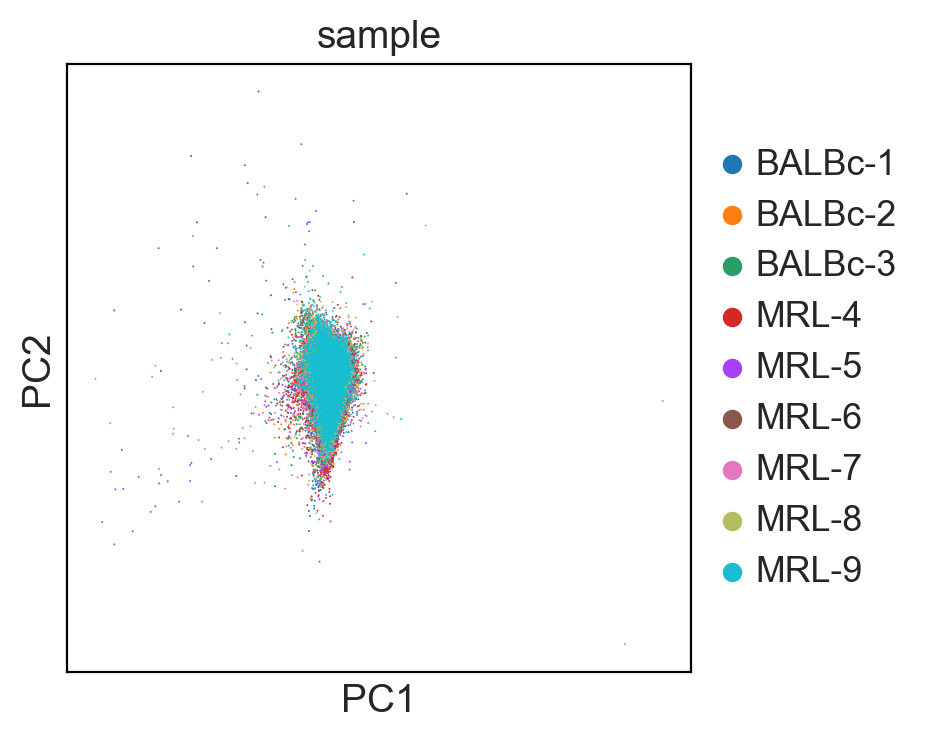

In [9]:
sc.pl.pca(
    adata,
    color=["sample"],
    size=2,
)

In [10]:
subset = adata[adata.obs['sample'] == 'BALBc-1']
pos = subset.obsm['spatial']
labels = subset.obs['cell_type']
result,_ = spn.compute_neighborhood_stats(pos, labels)

Using radius of 8592.609509589698


In [11]:
result['cell_type'] = list(labels)

In [12]:
sp = pd.DataFrame(subset.obsm['spatial'],columns=['x','y'] , index = subset.obs_names)
sp['cell_type'] = subset.obs['cell_type']   

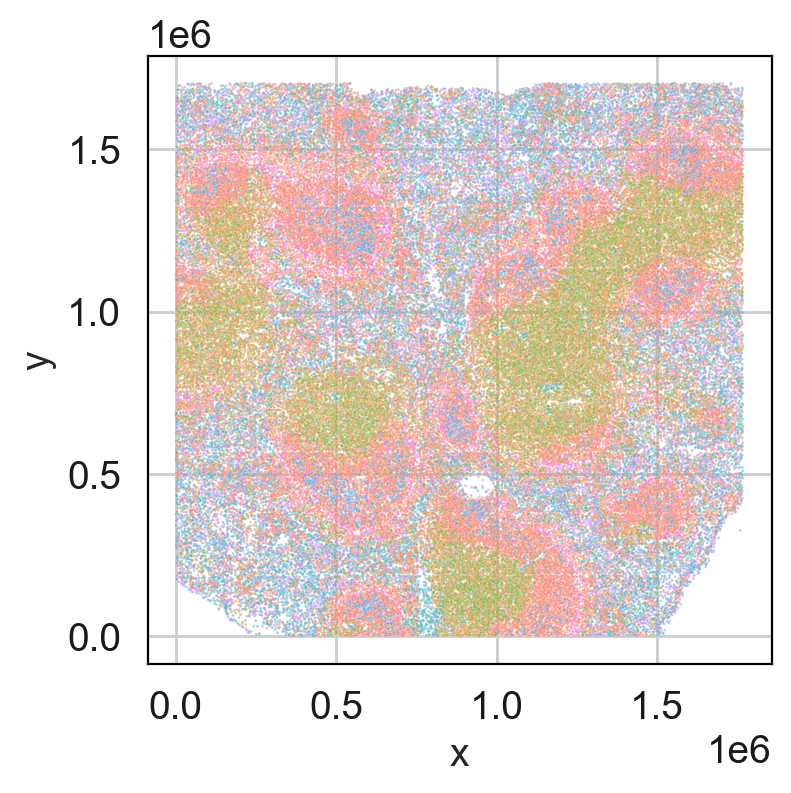

In [13]:
import matplotlib.pyplot as plt
sns.scatterplot(data=sp, x='x', y='y',
                hue ='cell_type' , s = 1, alpha = 0.5 )
plt.legend()
plt.gca().get_legend().set_visible(False)

In [14]:
fig_df = result.groupby('cell_type').mean().reset_index()
fig_df.index = fig_df['cell_type']
fig_df = fig_df.drop('cell_type', axis=1)
fig_df = fig_df.div(fig_df.sum(axis=1), axis=0)

In [15]:
import numpy as np
from scipy.stats import zscore
for i in range(fig_df.shape[1]):
    fig_df.iloc[i,:] = zscore(fig_df.iloc[i,:])
fig_df[np.isinf(fig_df)] = 0

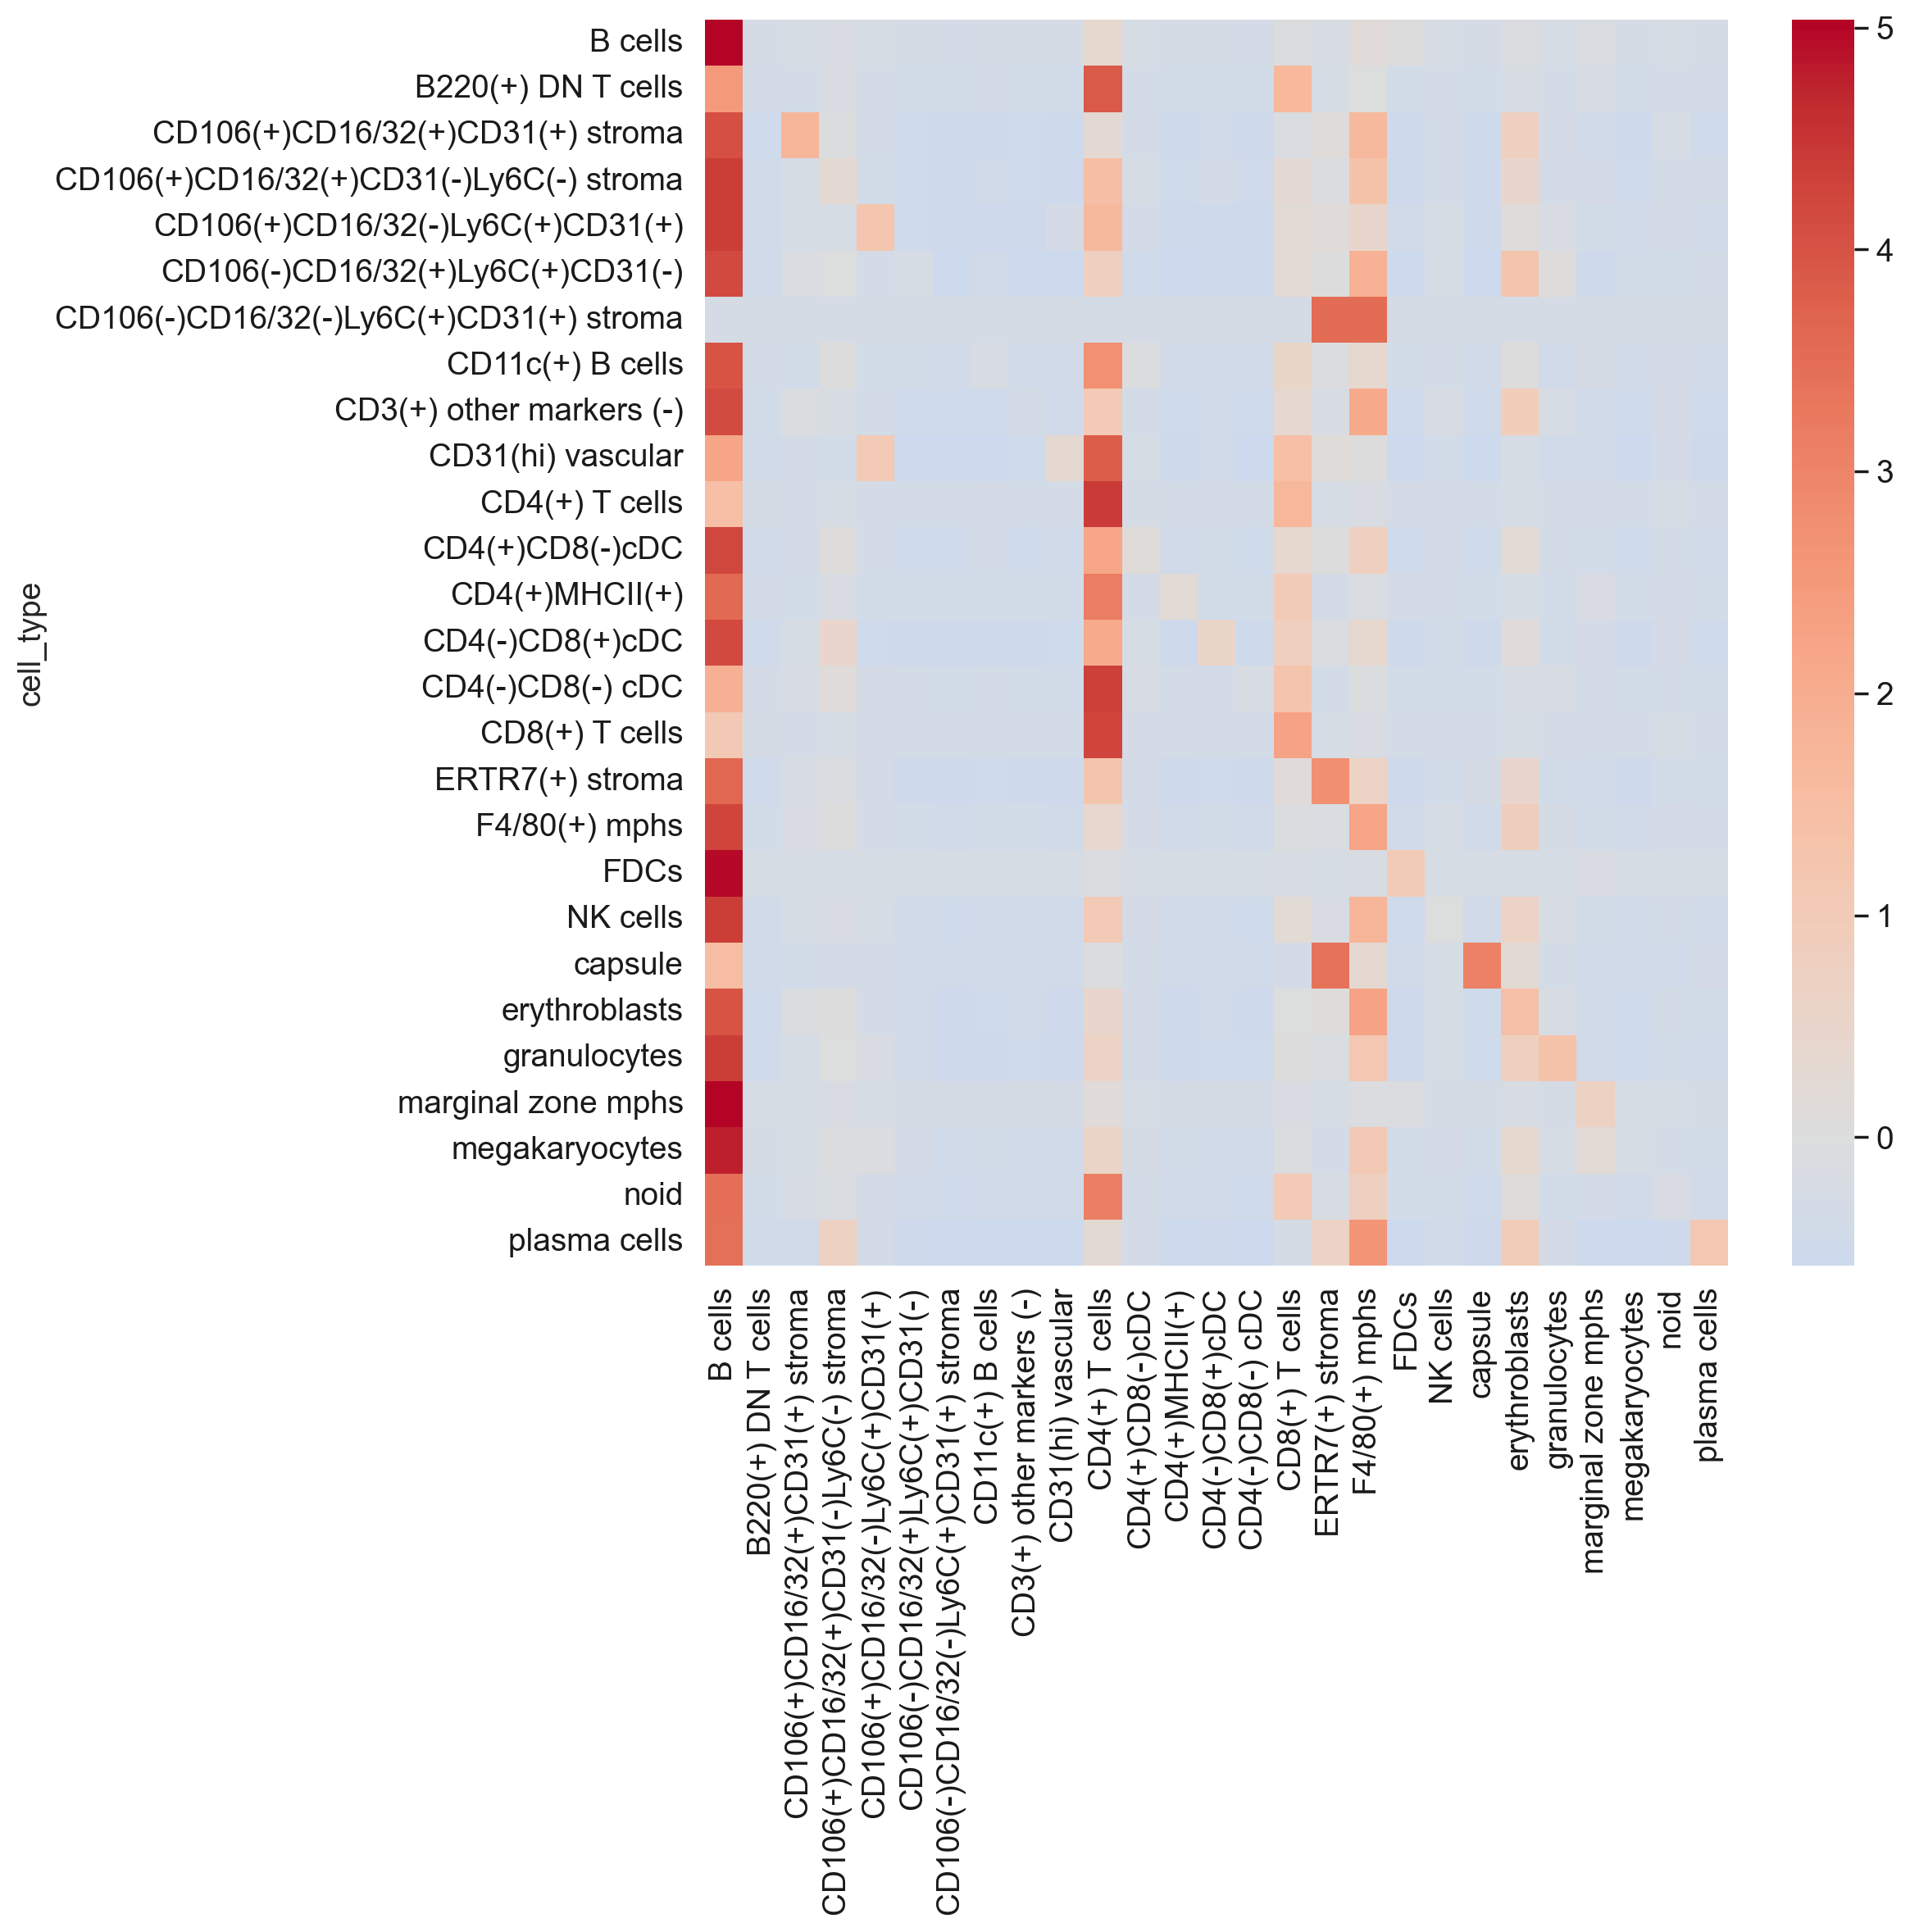

In [16]:
with rc_context({"figure.figsize": (10, 10)}):
    sns.heatmap(data=fig_df , cmap = 'coolwarm' , center = 0)

In [17]:
raw = adata.copy()

In [18]:
adata = raw.copy()

In [19]:
spn.neighborhood(adata,'sample',radius = 8000)

100%|██████████| 9/9 [00:13<00:00,  1.45s/it]


(<Figure size 1000x800 with 2 Axes>,
 <Axes: xlabel='cell_type', ylabel='center_cell'>)

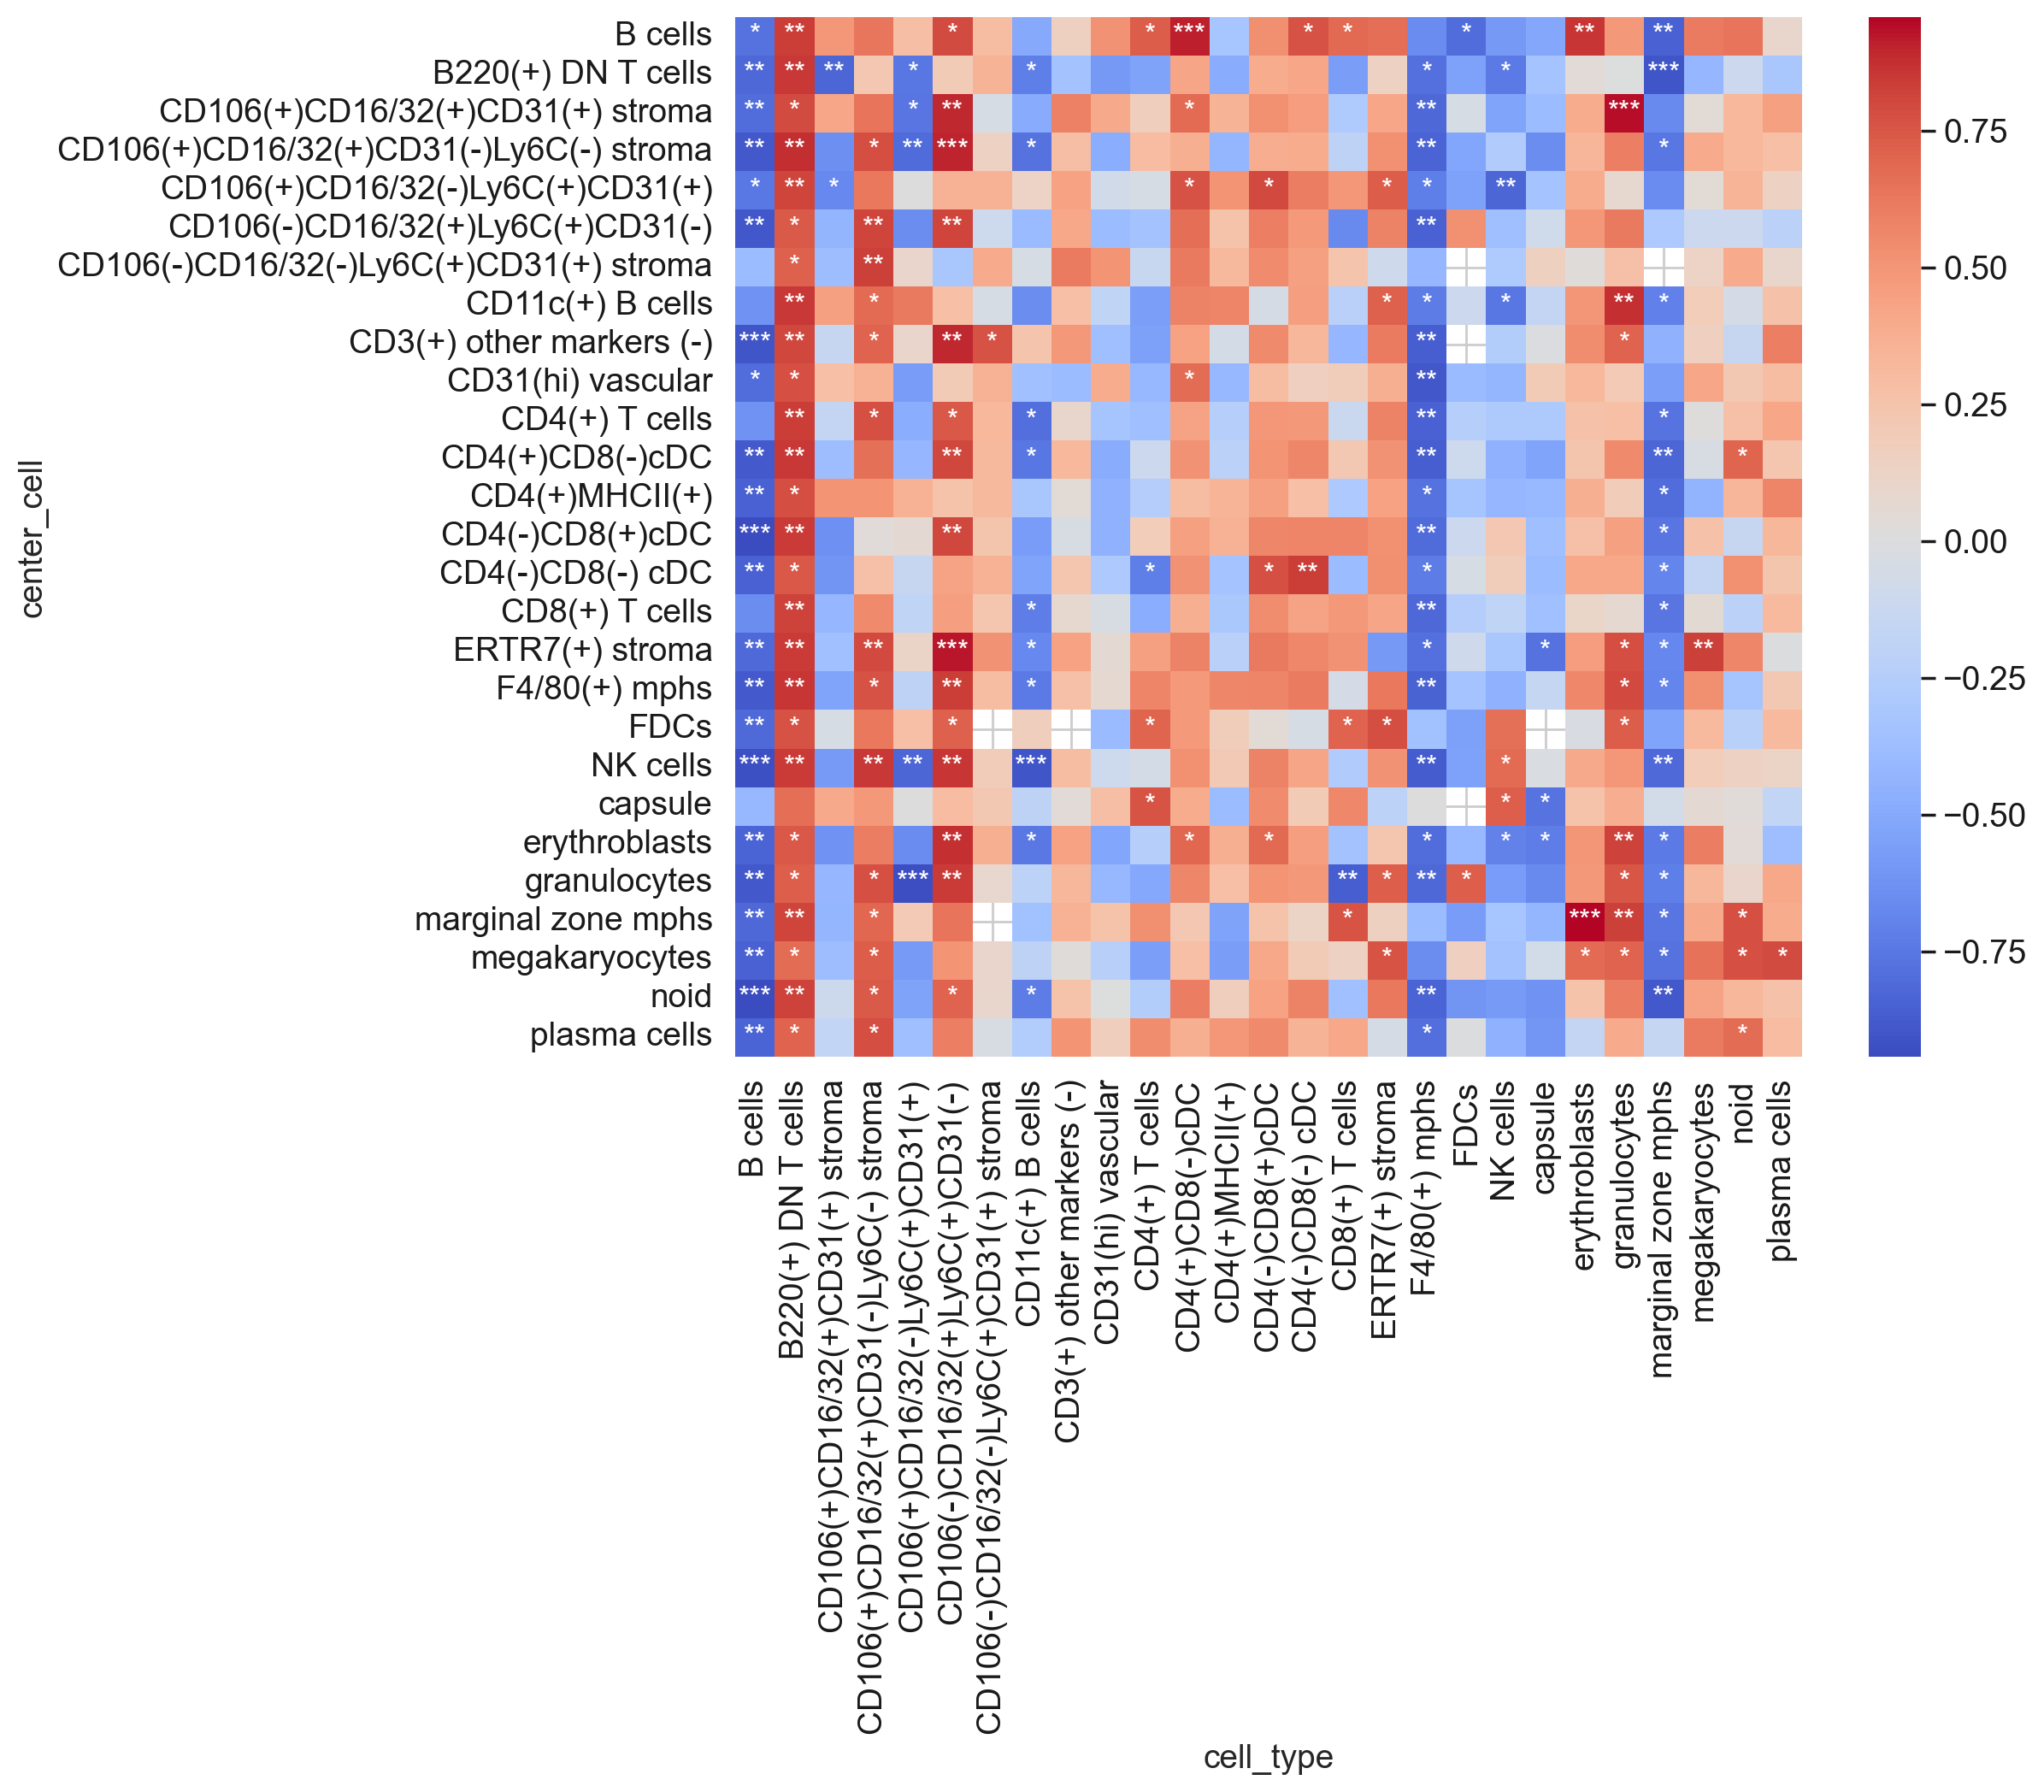

In [20]:
order_stage = {'BALBc' : 0 , 'early MRL' : 1 , 'intermediate MRL':2, 'late MRL' : 3}
spn.corr_pl(adata , order_stage,)

In [21]:
center_cell = 'B220(+) DN T cells'

fig_df[['cell_type' , 'stage' ,'sample']] = adata.obs[['cell_type' , 'stage' ,'sample']]
df = pd.DataFrame(adata.obsm['nbor_counts'],columns=adata.uns['nbor_label'] , index = adata.obs_names)
df[['sample' , 'stage' , 'cell_type'] ]= adata.obs[['sample' , 'stage' , 'cell_type']]
figdf = df.groupby(['sample','stage','cell_type']).mean().reset_index()

sub_fig_df = figdf[figdf['cell_type'] == center_cell]
sub_fig_df = sub_fig_df.dropna()
sub_fig_df.drop(['cell_type','sample'], axis=1, inplace=True)
sub_fig_df = sub_fig_df.groupby(['stage']).mean().reset_index()
sub_fig_df = sub_fig_df.melt(id_vars=['stage'], var_name='cell_type', value_name='variable')

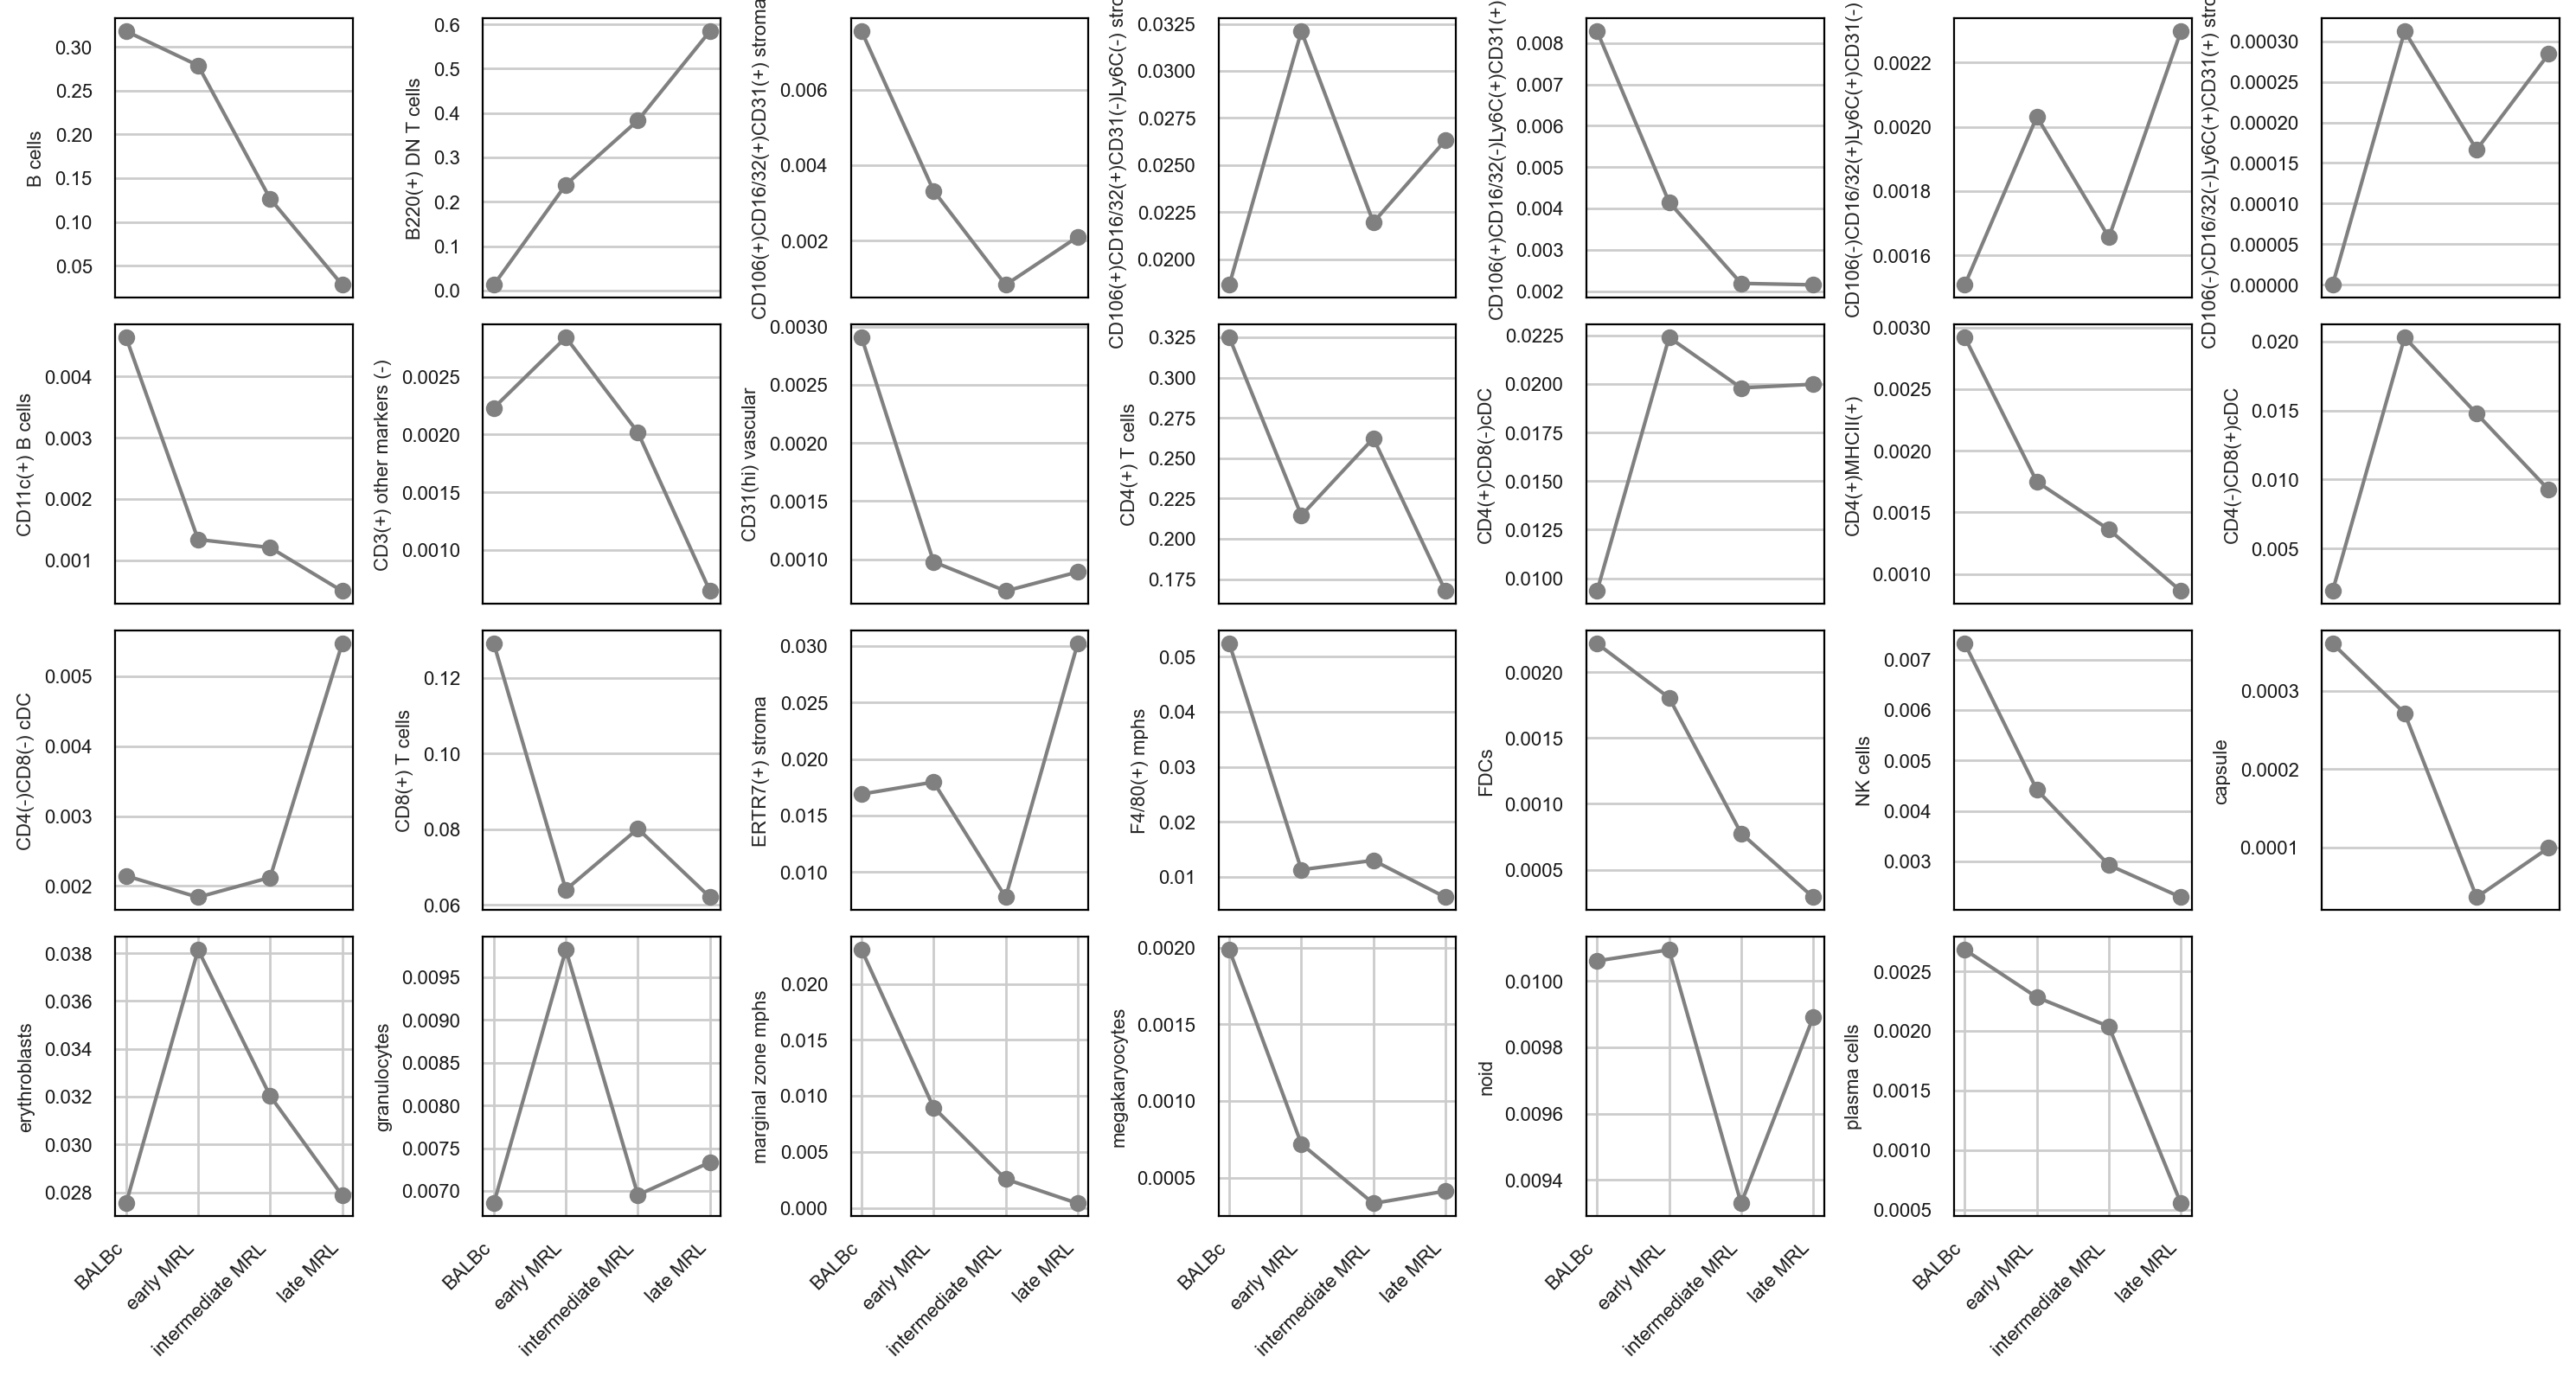

In [22]:
with rc_context({"figure.figsize": (10, 10) , "font.size": 8}):
    fig,axs = plt.subplots(4,7,figsize = (15,8))
    sub_fig_df['stage_num'] = sub_fig_df['stage'].map(order_stage)
    for i,cell in enumerate(sub_fig_df['cell_type'].unique()) :
        value = sub_fig_df[sub_fig_df['cell_type'] == cell].sort_values('stage_num')['variable']
        axs[i//7,i%7].plot(range(4),value , color = 'gray')
        axs[i//7,i%7].scatter(range(4),value, color = 'gray')
        axs[i//7,i%7].set_ylabel(sub_fig_df['cell_type'].unique()[i] , fontsize = 8)
        axs[i//7,i%7].set_xticks([], [],fontsize = 8)
        if i //7 == 3:
            axs[i//7,i%7].set_xticks(range(4),['BALBc' , 'early MRL' , 'intermediate MRL' , 'late MRL'],fontsize = 8,
                                     rotation = 45 , ha = 'right')
        axs[i//7,i%7].tick_params(axis='y', labelsize=8)
    axs[(i+1)//7,(i+1)%7].axis('off')
    plt.tight_layout()
    plt.show()

In [23]:
adata.write_h5ad('./data/codex_mouse_spleen_1.h5ad')

In [24]:
target = 'B220(+) DN T cells'

fig_df[['cell_type' , 'stage' ,'sample']] = adata.obs[['cell_type' , 'stage' ,'sample']]
df = pd.DataFrame(adata.obsm['nbor_counts'],columns=adata.uns['nbor_label'] , index = adata.obs_names)
df[['sample' , 'stage' , 'cell_type'] ]= adata.obs[['sample' , 'stage' , 'cell_type']]
figdf = df.groupby(['sample','stage','cell_type']).mean().reset_index()

sub_fig_df = figdf[['cell_type',target,'sample','stage']]
sub_fig_df = sub_fig_df.dropna()

In [25]:
sub_fig_df.drop(['sample'], axis=1, inplace=True)
sub_fig_df = sub_fig_df.groupby(['cell_type','stage']).mean().reset_index()

In [26]:
sub_fig_df.rename(columns = {target : 'variable'} , inplace = True)

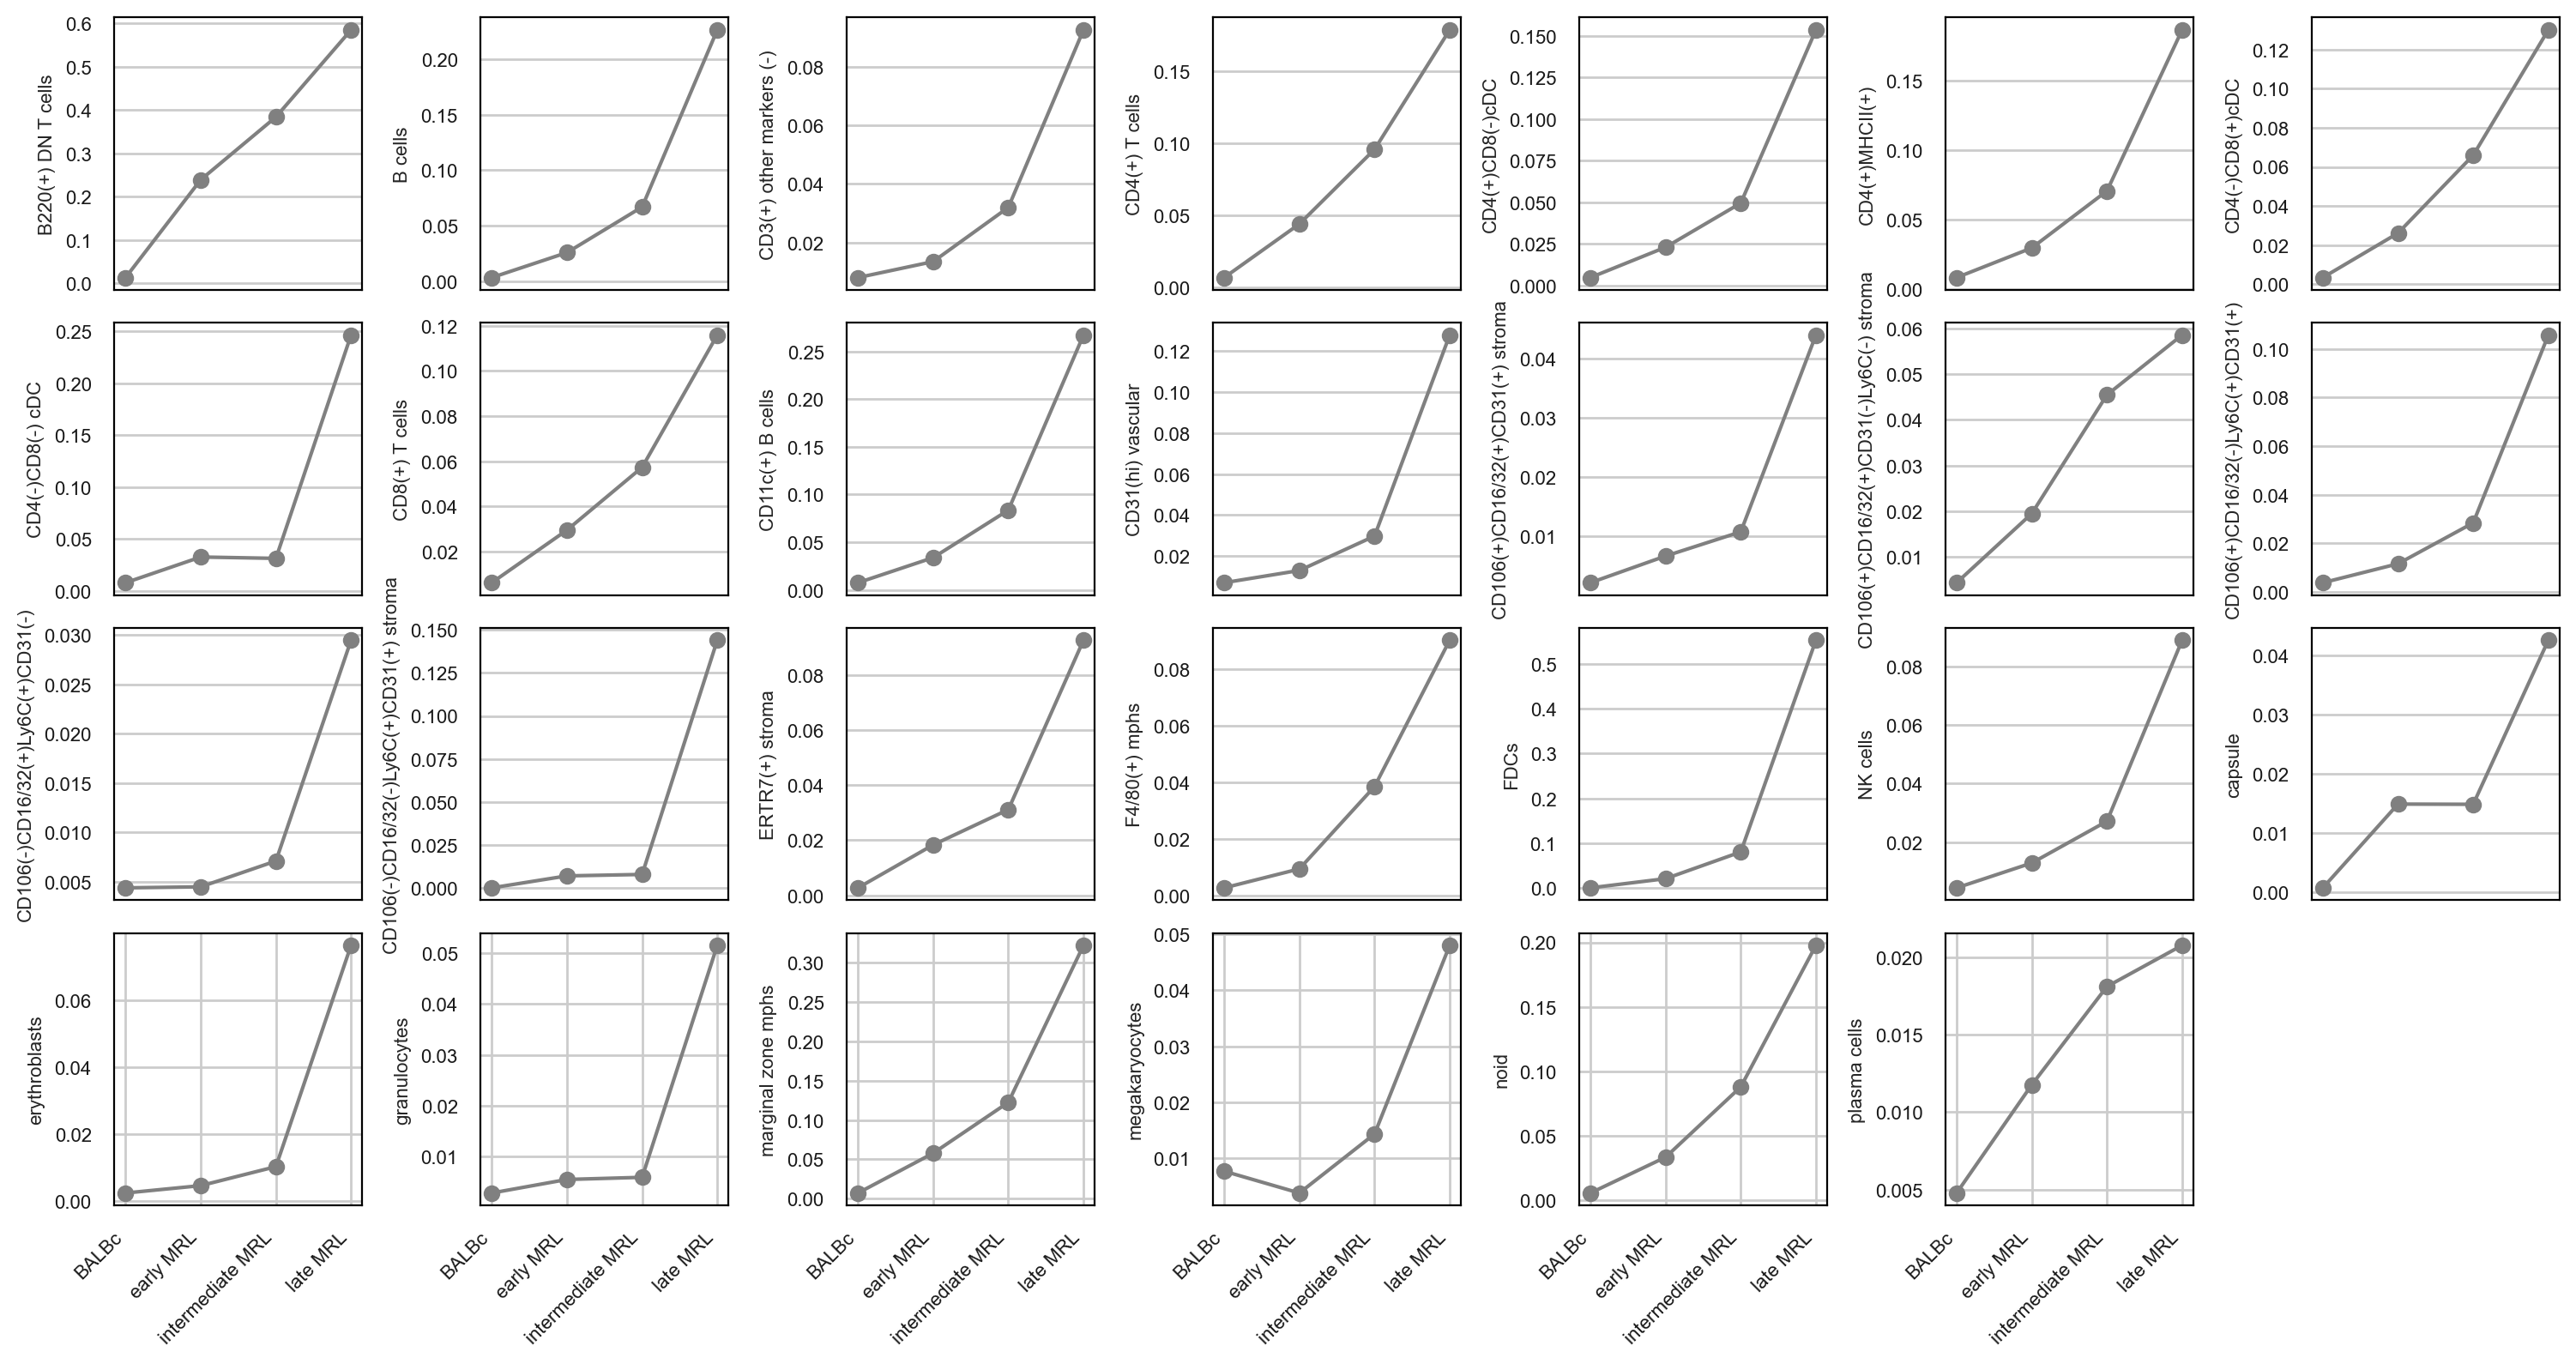

In [27]:
with rc_context({"figure.figsize": (10, 10) , "font.size": 8}):
    fig,axs = plt.subplots(4,7,figsize = (15,8))
    sub_fig_df['stage_num'] = sub_fig_df['stage'].map(order_stage)
    for i,cell in enumerate(sub_fig_df['cell_type'].unique()) :
        value = sub_fig_df[sub_fig_df['cell_type'] == cell].sort_values('stage_num')['variable']
        axs[i//7,i%7].plot(range(4),value , color = 'gray')
        axs[i//7,i%7].scatter(range(4),value, color = 'gray')
        axs[i//7,i%7].set_ylabel(sub_fig_df['cell_type'].unique()[i] , fontsize = 8)
        axs[i//7,i%7].set_xticks([], [],fontsize = 8)
        if i //7 == 3:
            axs[i//7,i%7].set_xticks(range(4),['BALBc' , 'early MRL' , 'intermediate MRL' , 'late MRL'],fontsize = 8,
                                     rotation = 45 , ha = 'right')
        axs[i//7,i%7].tick_params(axis='y', labelsize=8)
    axs[(i+1)//7,(i+1)%7].axis('off')
    plt.tight_layout()
    plt.show()

In [598]:
import SpatialCell.cn.build_graph as scbg
import SpatialCell.cn.subgraph_embedding as sce
importlib.reload(scbg)
importlib.reload(sce)

<module 'SpatialCell.cn.subgraph_embedding' from 'f:\\HLL\\SpatialCell\\SpatialCell\\cn\\subgraph_embedding.py'>

In [467]:
mydata = scbg.GraphDataset(adata , 'sample' , 'cell_type' , 'spatial')

In [468]:
encorder = mydata.encorder

10    25
0      6
15     5
3      2
7      1
14     1
Name: count, dtype: int64

(<Figure size 400x400 with 1 Axes>, <Axes: >)

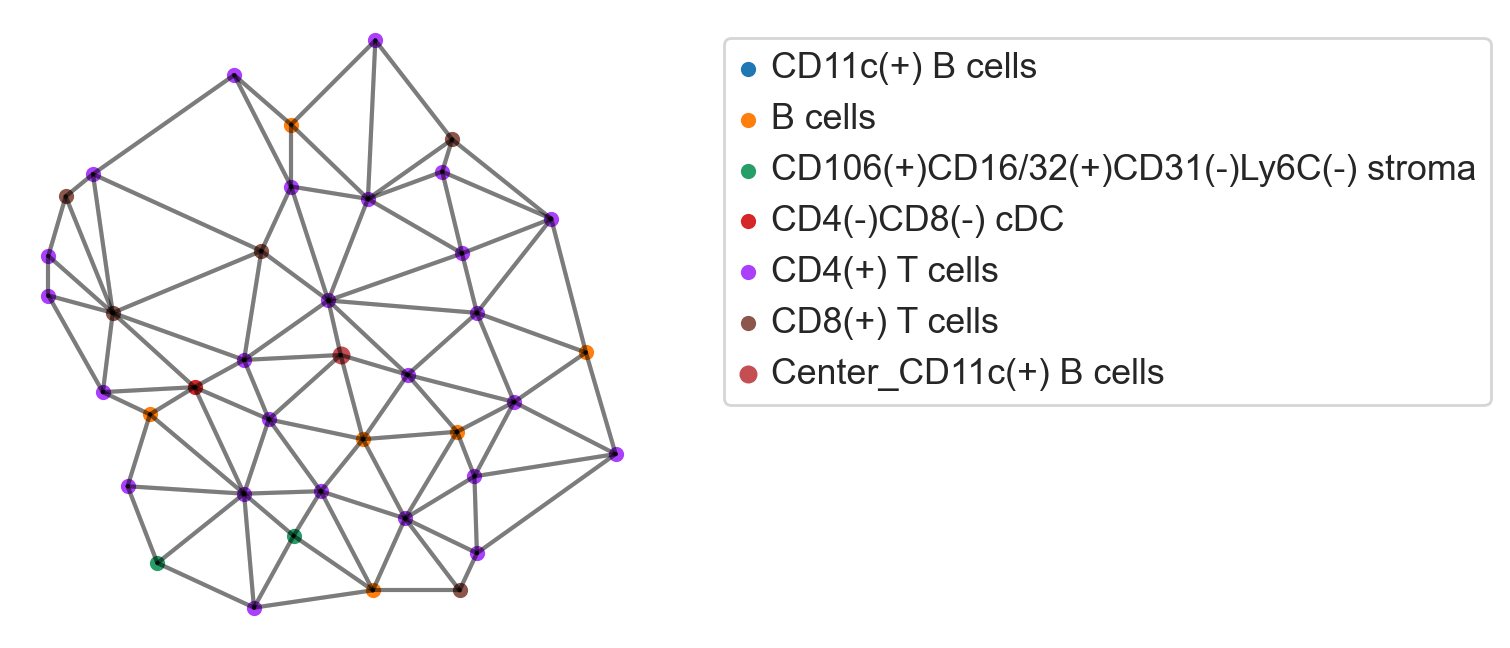

In [472]:
subg = mydata.get_subgraph('BALBc-1' , 0,3)
mydata.plG(subg)

In [599]:
k = 3
sample_pool, sample_cells = sce.embedding(mydata , k , target)  #后续还需要修改，将subgraph保存到类里，不需要每次都重新计算

  0%|          | 0/9 [00:01<?, ?it/s]

Processing batch id = BALBc-1 , cell count = 327


 11%|█         | 1/9 [00:07<00:49,  6.25s/it]

Processing batch id = BALBc-2 , cell count = 309


 22%|██▏       | 2/9 [00:12<00:38,  5.49s/it]

Processing batch id = BALBc-3 , cell count = 441


 33%|███▎      | 3/9 [00:18<00:34,  5.70s/it]

Processing batch id = MRL-4 , cell count = 1092


 44%|████▍     | 4/9 [00:31<00:42,  8.58s/it]

Processing batch id = MRL-5 , cell count = 1385


 56%|█████▌    | 5/9 [00:47<00:44, 11.05s/it]

Processing batch id = MRL-6 , cell count = 4419


 67%|██████▋   | 6/9 [01:35<01:10, 23.63s/it]

Processing batch id = MRL-7 , cell count = 1476


 78%|███████▊  | 7/9 [01:54<00:44, 22.07s/it]

Processing batch id = MRL-8 , cell count = 14015


 89%|████████▉ | 8/9 [04:29<01:04, 64.54s/it]

Processing batch id = MRL-9 , cell count = 17561


100%|██████████| 9/9 [07:44<00:00, 51.56s/it] 


In [608]:
encorder = mydata.encorder

In [620]:
nbh_1 = pd.concat([pd.DataFrame([i[0] for i in sample_cells[j]]).fillna(0) for j in range(len(sample_cells))])
nbh_1.columns = encorder.inverse_transform(nbh_1.columns)

nbh_2 = pd.concat([pd.DataFrame([i[1] for i in sample_cells[j]]).fillna(0) for j in range(len(sample_cells))])
nbh_2.columns = encorder.inverse_transform(nbh_2.columns)

nbh_3 = pd.concat([pd.DataFrame([i[2] for i in sample_cells[j]]).fillna(0) for j in range(len(sample_cells))])
nbh_3.columns = encorder.inverse_transform(nbh_3.columns)

In [624]:
nbh_1.fillna(0 , inplace=True)
nbh_2.fillna(0, inplace=True)
nbh_3.fillna(0, inplace=True)

In [506]:
embedding_df = pd.concat(sample_pool)

In [518]:
from SpatialCell.cn import GMM

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_standardized = scaler.fit_transform(embedding_df.drop(['index' , 'sample'] , axis = 1).values)

In [541]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import fowlkes_mallows_score
from tqdm import tqdm

def calculate_fmi(labels_true, labels_pred):
    """
    计算 FMI，使用 Fowlkes-Mallows 指标
    """
    return fowlkes_mallows_score(labels_true, labels_pred)

def stability_based_clustering(data, k_min, k_max, max_runs, tolerance=0.01):
    """
    基于聚类稳定性选择最佳K
    """
    best_k = None
    best_fmi = -np.inf
    stability_scores = {}
    kscores = []
    # 遍历K值范围
    for k in tqdm(range(k_min, k_max+1)):
        fmi_scores = []
        
        # 对每个K进行多次聚类
        for r in range(max_runs):
            gmm = GaussianMixture(n_components=k, random_state=r)
            labels = gmm.fit_predict(data)
            
            if r > 0:
                prev_labels = prev_labels  # 上一次聚类的标签
                fmi_km1_k = calculate_fmi(prev_labels, labels)
                fmi_k_kp1 = calculate_fmi(prev_labels, labels)
                fmi_scores.append((fmi_km1_k + fmi_k_kp1) / 2)
                
            prev_labels = labels  # 存储当前聚类标签
        kscores.append(fmi_scores)
        avg_fmi = np.mean(fmi_scores)
        stability_scores[k] = avg_fmi
        
        # 收敛判断：检查上一次和当前的FMI是否有显著变化
        if len(fmi_scores) > 1:
            relative_change = abs(fmi_scores[-1] - fmi_scores[-2]) / fmi_scores[-2]
            if relative_change < tolerance:
                print(f"Converged for K={k}, stopping early")
                break
        
        if avg_fmi > best_fmi:
            best_fmi = avg_fmi
            best_k = k

    return best_k, stability_scores,kscores



In [ ]:
k_min = 5
k_max = 15
max_runs = 20

best_k, stability_scores,kscores = stability_based_clustering(data_standardized, k_min, k_max, max_runs)

print(f"Best K: {best_k}")
print("Stability scores:", stability_scores)

In [548]:
df = pd.DataFrame(kscores, index = range(k_min, k_max+1)).T.melt()

In [549]:
df.head()

variable     value
0         5  0.940713
1         5  0.837234
2         5  0.914690
3         5  0.661606
4         5  0.674153

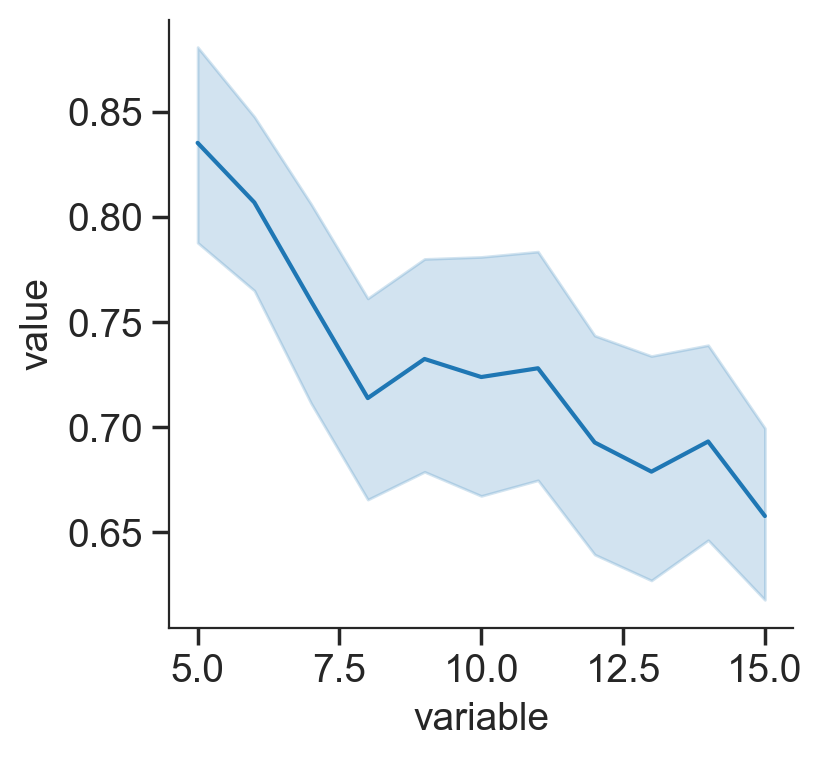

In [577]:
sns.set_style("ticks")
sns.lineplot(x="variable", y="value", data=df)
sns.despine()


In [531]:
from sklearn.mixture import GaussianMixture
random_state = 42
gmm = GaussianMixture(n_components=6, random_state=random_state)
gmm.fit(data_standardized)
labels = gmm.predict(data_standardized)

In [534]:
import umap

umap_model = umap.UMAP(n_components=2,
                       random_state=42 ,
                       n_neighbors = 5)  # 降到二维
# 拟合数据并进行降维


In [556]:
X_umap = umap_model.fit_transform(data_standardized)

In [572]:
def plot_embedding(X, labels, title):
    """
    绘制嵌入结果
    """
    cmap = plt.cm.tab20c
    colors = [cmap(i) for i in np.linspace(0, 1, len(np.unique(labels)))]
    for n,i in enumerate(np.unique(labels)):
        plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f"Cluster {i}" , s = 0.1 ,c = colors[n])
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


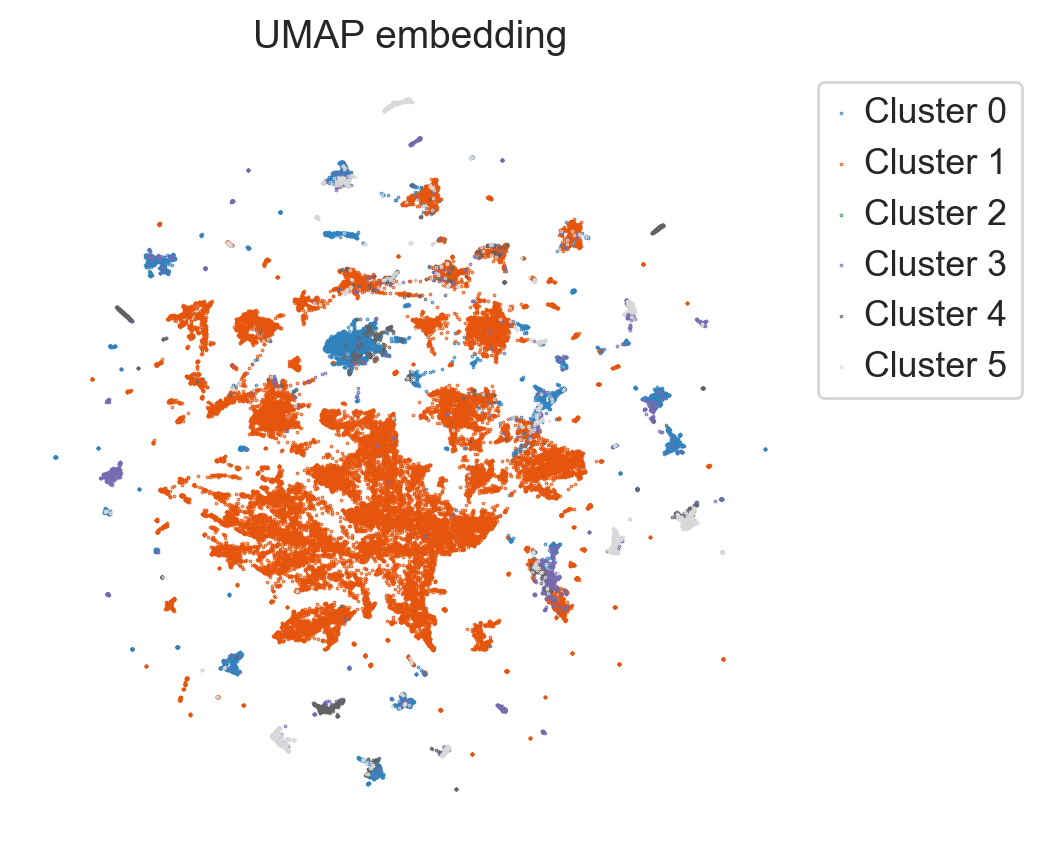

In [578]:
fig, ax = plt.subplots(figsize=(5,5))
plot_embedding(X_umap, labels, "UMAP embedding")
for spine in ax.spines.values():
            spine.set_visible(False)
ax.grid(False)
ax.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)

In [626]:
nbh_1['label'] = labels
nbh_2['label'] = labels
nbh_3['label'] = labels


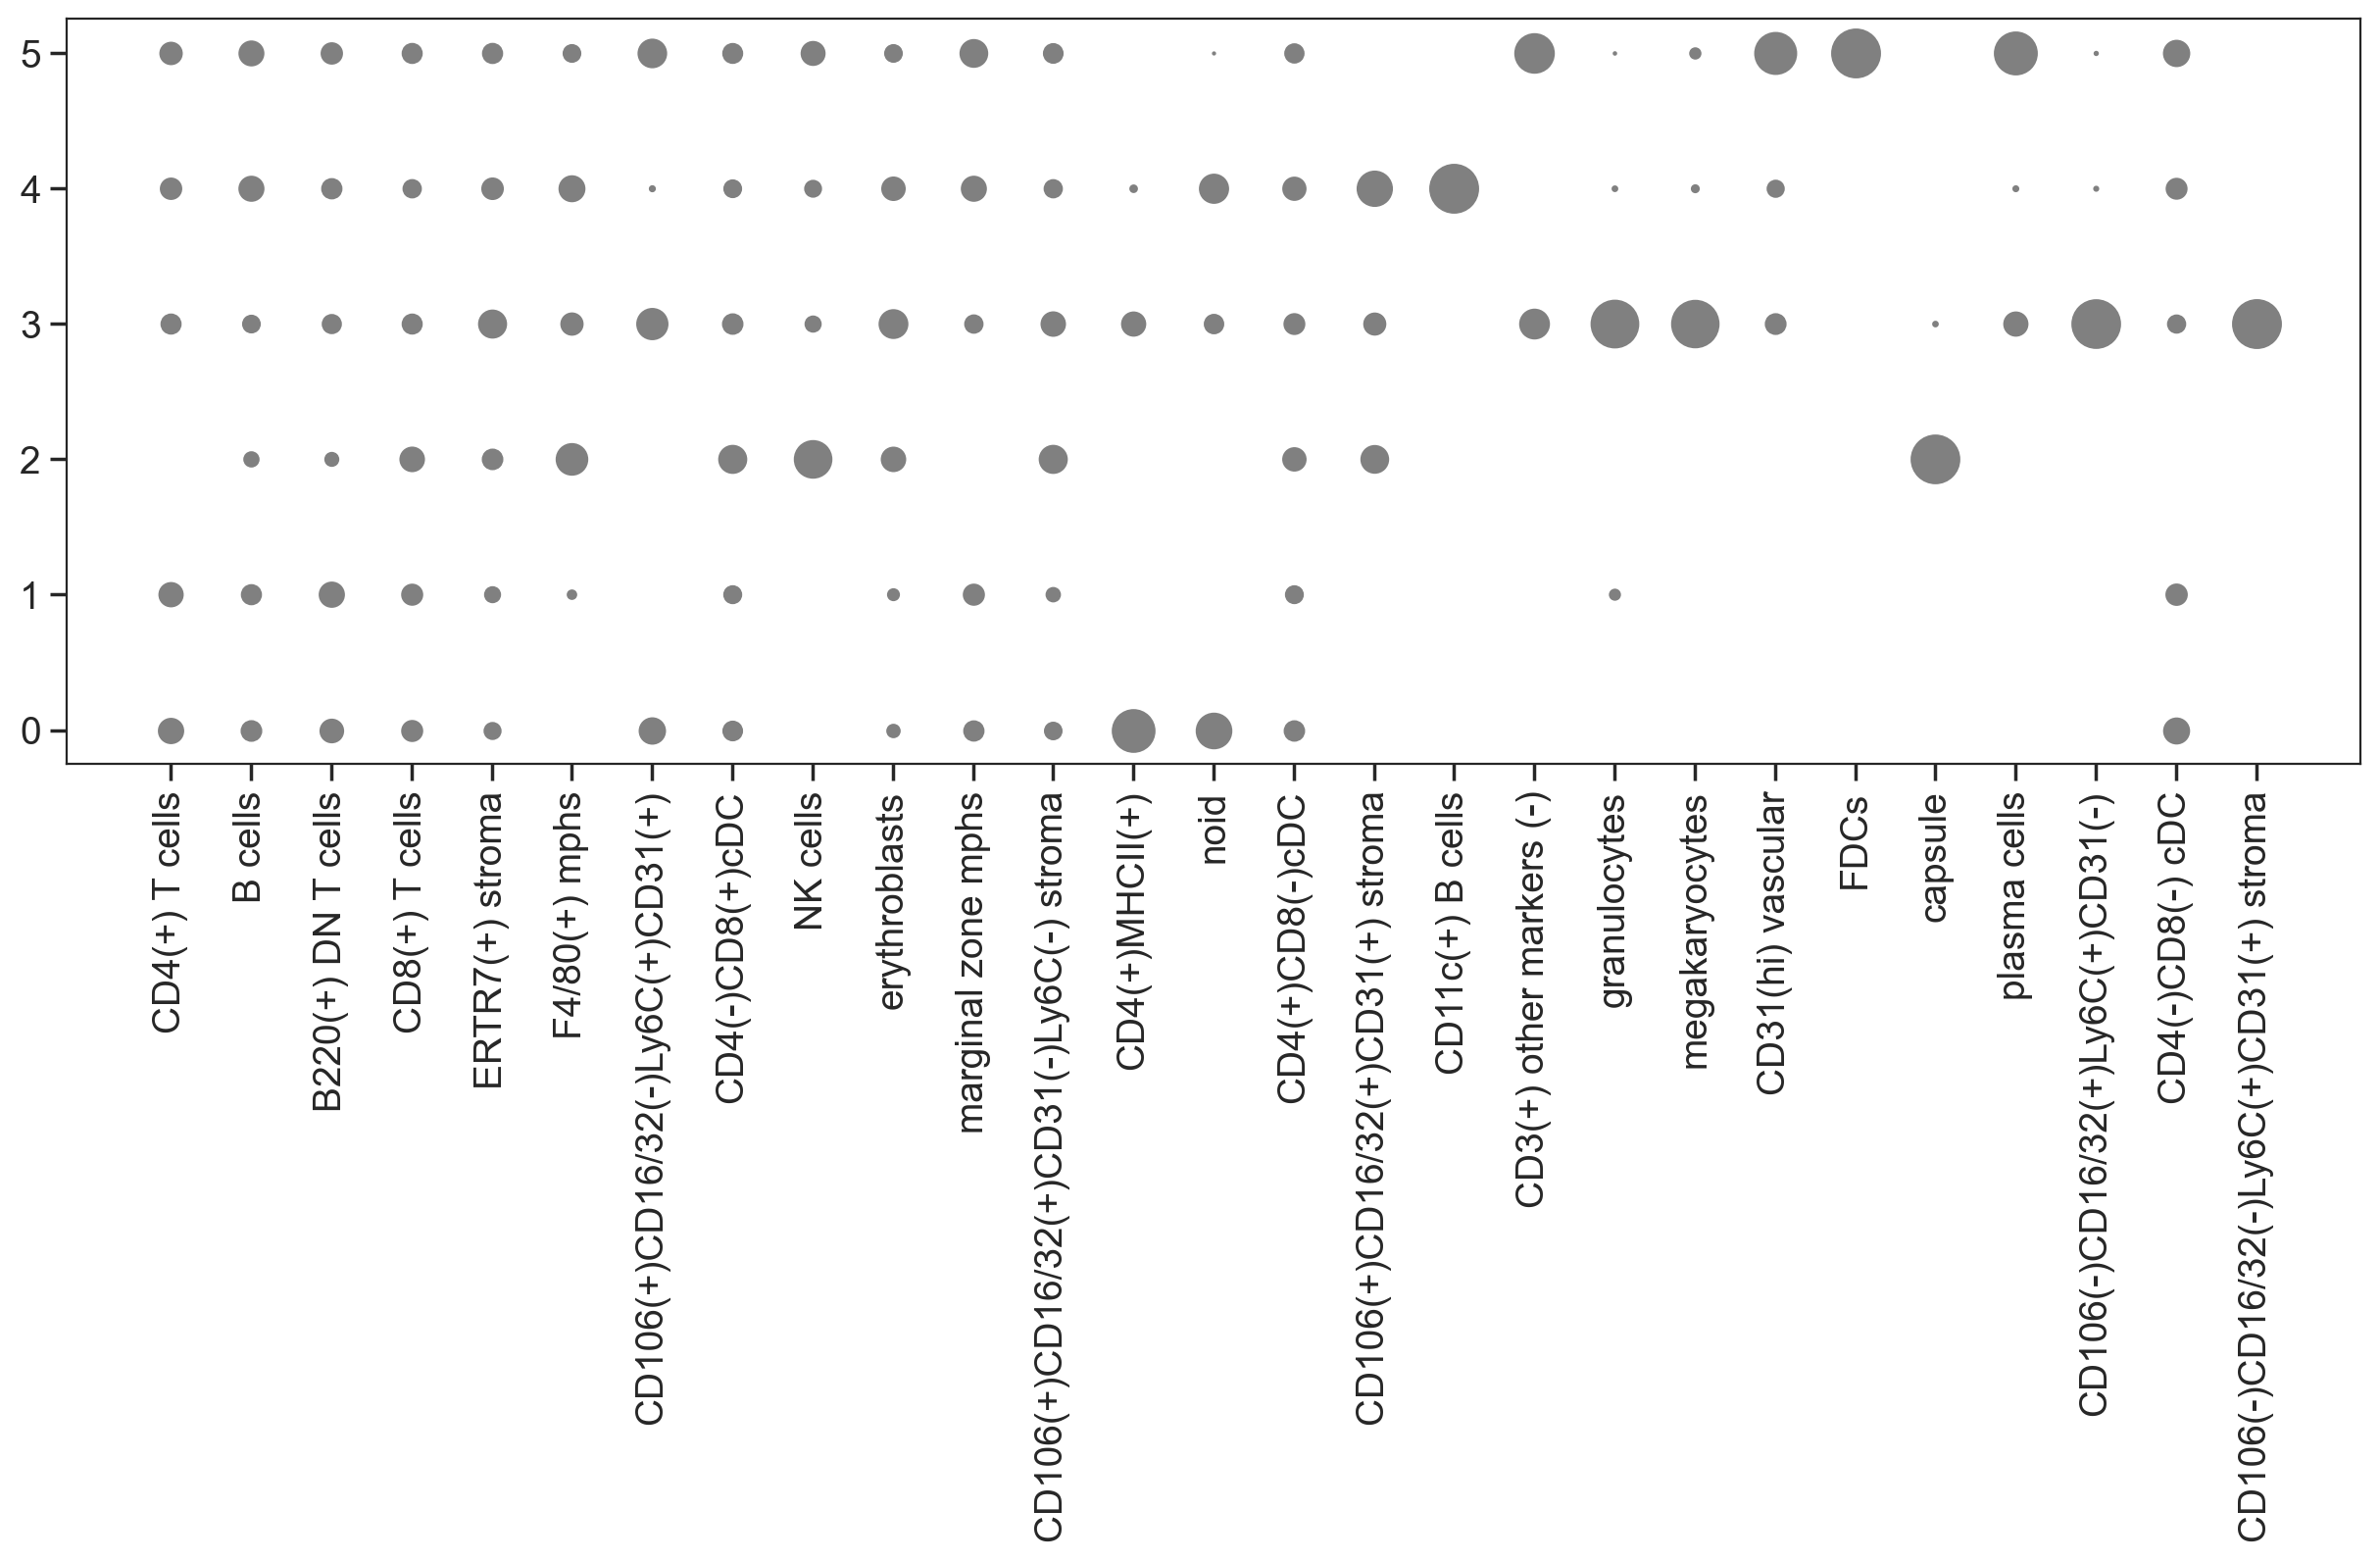

In [ ]:
import scipy.stats as stats

fig_df = nbh_1.groupby('label').mean()
fig_df = fig_df/ fig_df.mean(axis=0)
fig,ax = plt.subplots(figsize = (15,5))
for i in range(fig_df.shape[1]):
    for j in range(fig_df.shape[0]):
        plt.scatter(i,j, s = fig_df.iloc[j,i]*50 , color = 'gray')
        group_interested = nbh_1[fig_df.columns[i]][nbh_1['label'] == j].values
        other_groups = nbh_1[fig_df.columns[i]][nbh_1['label'] != j].values
        t_statistic, p_value = stats.ttest_ind(group_interested, other_groups)
plt.xticks(range(fig_df.shape[1]),fig_df.columns , rotation = 90)
plt.show()

In [ ]:
# 获取每个细胞的疾病进程

nbh_1['sample'] = list(embedding_df['sample'])
stagemap = {i:adata[adata.obs['sample'] == i].obs['stage'].values[0] for i in adata.obs['sample'].unique()}
nbh_1['stage'] = nbh_1['sample'].map(stagemap)
nbh_1['stage_nun'] = nbh_1['stage'].map(order_stage)

In [723]:
# 计算类型邻域在不同疾病阶段的比例
rs = {}
for n,i in enumerate(nbh_1['stage_nun'].unique()):
    fig_df = nbh_1[nbh_1['stage_nun'] == i]['label'].value_counts()
    rs[i] = fig_df/fig_df.sum()
rs = pd.DataFrame(rs ).fillna(0)

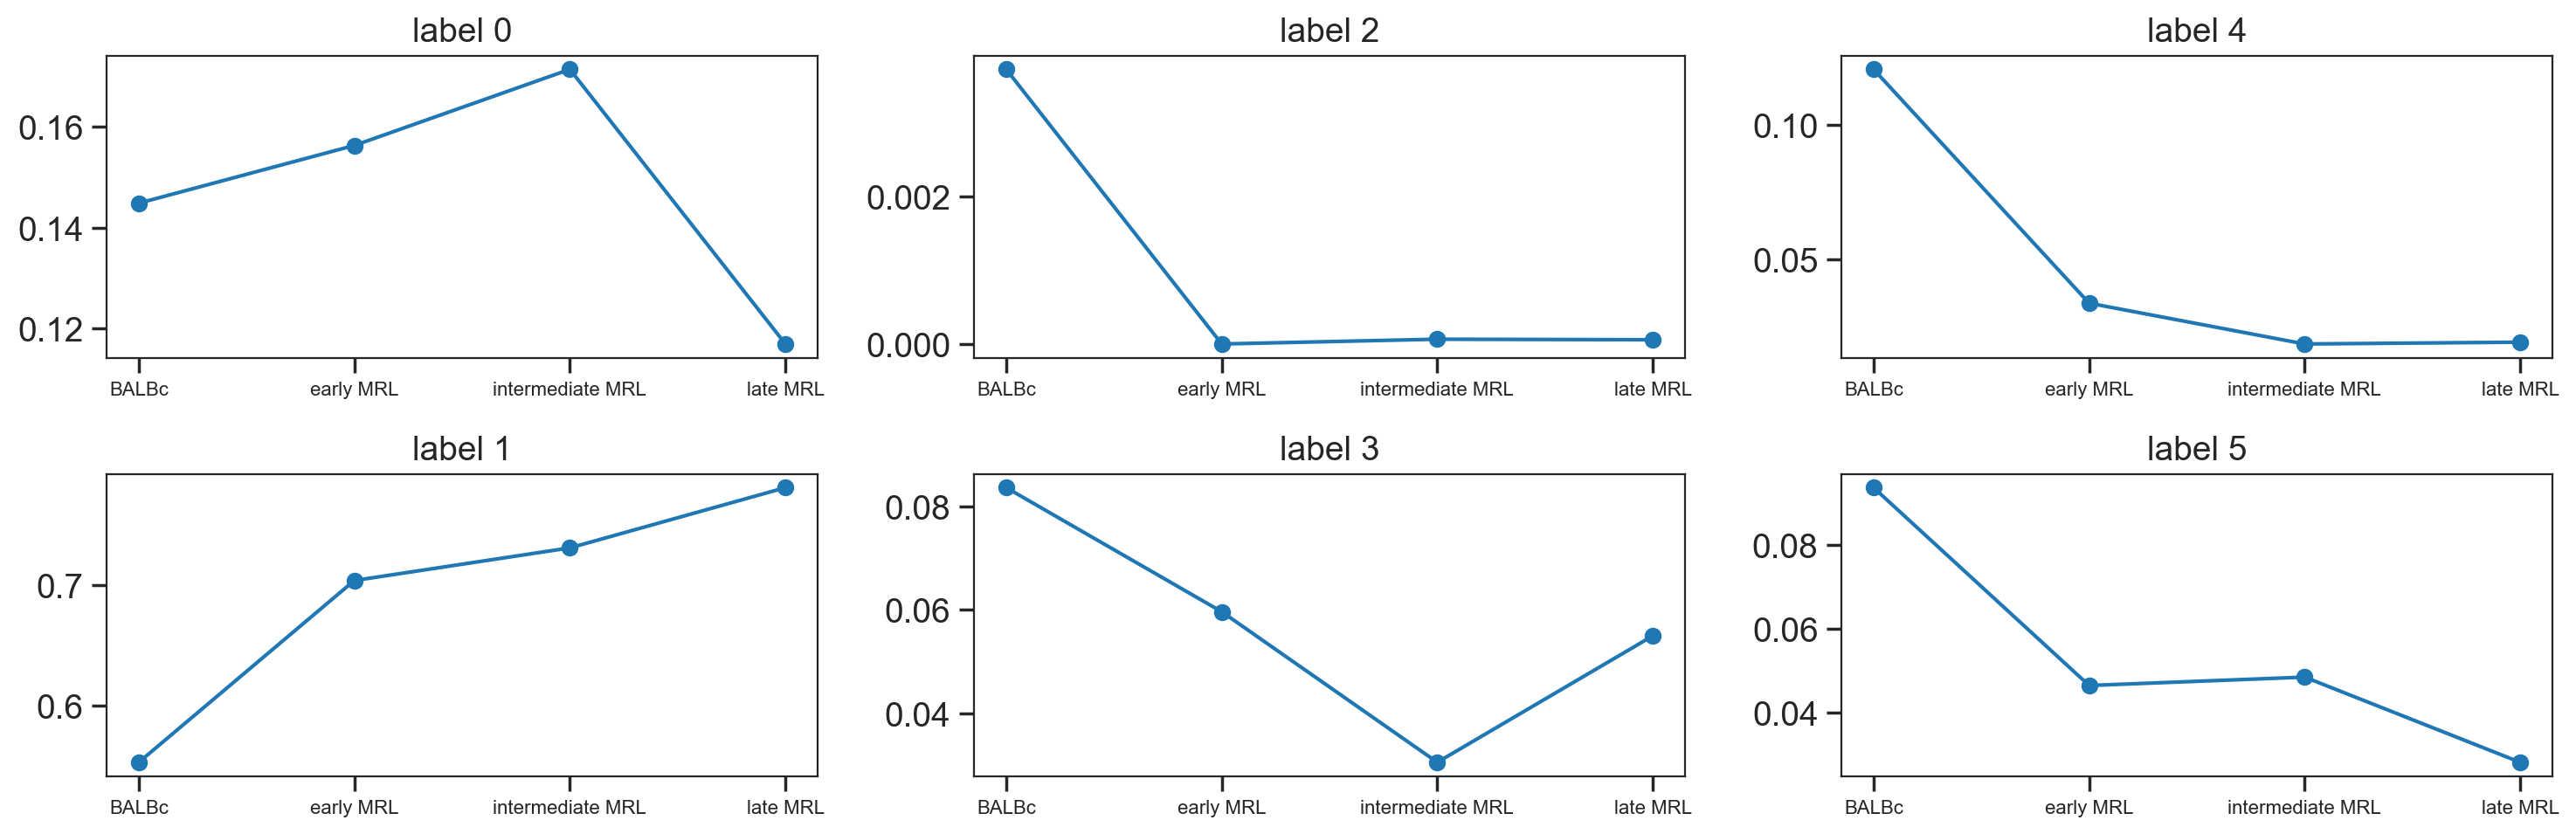

In [734]:
fig,axs = plt.subplots(2,round(len(nbh_1['label'].unique())/2),figsize = (15,5))
for i in range(rs.shape[0]):
    axs[i%2 , i//2].plot(range(4), rs.iloc[i,:])
    axs[i%2 , i//2].scatter(range(4), rs.iloc[i,:])
    axs[i%2 , i//2].set_title(f'label {i}')
    axs[i%2 , i//2].set_xticks(range(4),['BALBc' , 'early MRL' , 'intermediate MRL' , 'late MRL'],fontsize = 8,)
plt.tight_layout()